## **Librerias**

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

## **Preparación de Datos**

In [2]:
df_closed = pd.read_csv("../data/raw/olist_closed_deals_dataset.csv")
#
df_mkt = pd.read_csv("../data/raw/olist_marketing_qualified_leads_dataset.csv")

In [3]:
df_mkt_closed = df_mkt.merge(df_closed, on='mql_id', how='left')
#
df_processed = df_mkt_closed.assign(
        first_contact_date=lambda df: pd.to_datetime(df_mkt_closed['first_contact_date'], format='%Y-%m-%d', errors='coerce'),
        won_date= pd.to_datetime(df_mkt_closed['won_date'].str[:10], format='%Y-%m-%d', errors='coerce'),)
#
df_processed['contact_period'] = df_processed['first_contact_date'].astype(str).str[:7]

## **Exploración Series de Tiempo**

In [4]:
mql_daily_series = df_processed.groupby('first_contact_date', as_index=False).agg(mql_count=('mql_id', 'count'))\
                                .sort_values('first_contact_date')
#
mql_period_series = df_processed.groupby('contact_period', as_index=False).agg(mql_count=('mql_id', 'count'))\
            .sort_values('contact_period')
#
mql_series = df_processed.groupby(['first_contact_date', 'contact_period'], as_index=False).agg(mql_count=('mql_id', 'count'))
#
# Reindexar a frecuencia diaria completa
full_range = pd.date_range(start=mql_daily_series['first_contact_date'].min(), end=mql_daily_series['first_contact_date'].max(), freq='D')
mql_daily_series = mql_daily_series.set_index('first_contact_date').reindex(full_range).fillna(0).rename_axis('first_contact_date').reset_index()

# Asegúrate de que la columna de valores es numérica
mql_daily_series['mql_count'] = mql_daily_series['mql_count'].astype(int)

In [246]:
px.line(mql_daily_series, x='first_contact_date', y='mql_count', title='MQLs por día')

In [247]:
px.line(mql_period_series, x='contact_period', y='mql_count', title='MQLs por día')

In [248]:
px.box(mql_series, x='contact_period', y='mql_count')

## **Modelamiento Diario mqls**

In [6]:
from darts import TimeSeries
import matplotlib.pyplot as plt
import plotly.graph_objects as go
#
import os
# Crear objeto TimeSeries
series = TimeSeries.from_dataframe(mql_daily_series, 'first_contact_date', 'mql_count')

In [7]:
from darts.metrics import mae
from darts.models import NaiveSeasonal, NaiveDrift, LinearRegressionModel
from darts.models import ExponentialSmoothing, Prophet, ARIMA, Theta

Entrenando NaiveSeasonal...


historical forecasts:   0%|          | 0/8 [00:00<?, ?it/s]

NaiveSeasonal - MAE: 25.12
Entrenando ExponentialSmoothing...


C:\Users\Acer\AppData\Local\Temp\ipykernel_9292\2511464014.py:41: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



historical forecasts:   0%|          | 0/8 [00:00<?, ?it/s]

17:29:28 - cmdstanpy - INFO - Chain [1] start processing


ExponentialSmoothing - MAE: 12.31
Entrenando Prophet...


17:29:28 - cmdstanpy - INFO - Chain [1] done processing


historical forecasts:   0%|          | 0/8 [00:00<?, ?it/s]

17:29:28 - cmdstanpy - INFO - Chain [1] start processing
17:29:28 - cmdstanpy - INFO - Chain [1] done processing
17:29:28 - cmdstanpy - INFO - Chain [1] start processing
17:29:28 - cmdstanpy - INFO - Chain [1] done processing
17:29:29 - cmdstanpy - INFO - Chain [1] start processing
17:29:29 - cmdstanpy - INFO - Chain [1] done processing
17:29:29 - cmdstanpy - INFO - Chain [1] start processing
17:29:29 - cmdstanpy - INFO - Chain [1] done processing
17:29:29 - cmdstanpy - INFO - Chain [1] start processing
17:29:29 - cmdstanpy - INFO - Chain [1] done processing
17:29:29 - cmdstanpy - INFO - Chain [1] start processing
17:29:29 - cmdstanpy - INFO - Chain [1] done processing
17:29:30 - cmdstanpy - INFO - Chain [1] start processing
17:29:30 - cmdstanpy - INFO - Chain [1] done processing
17:29:30 - cmdstanpy - INFO - Chain [1] start processing
17:29:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet - MAE: 11.91
Entrenando ARIMA...


historical forecasts:   0%|          | 0/8 [00:00<?, ?it/s]

ARIMA - MAE: 17.33

Resultados finales:
                  Model        MAE
2               Prophet  11.909233
1  ExponentialSmoothing  12.313159
3                 ARIMA  17.333172
0         NaiveSeasonal  25.125000


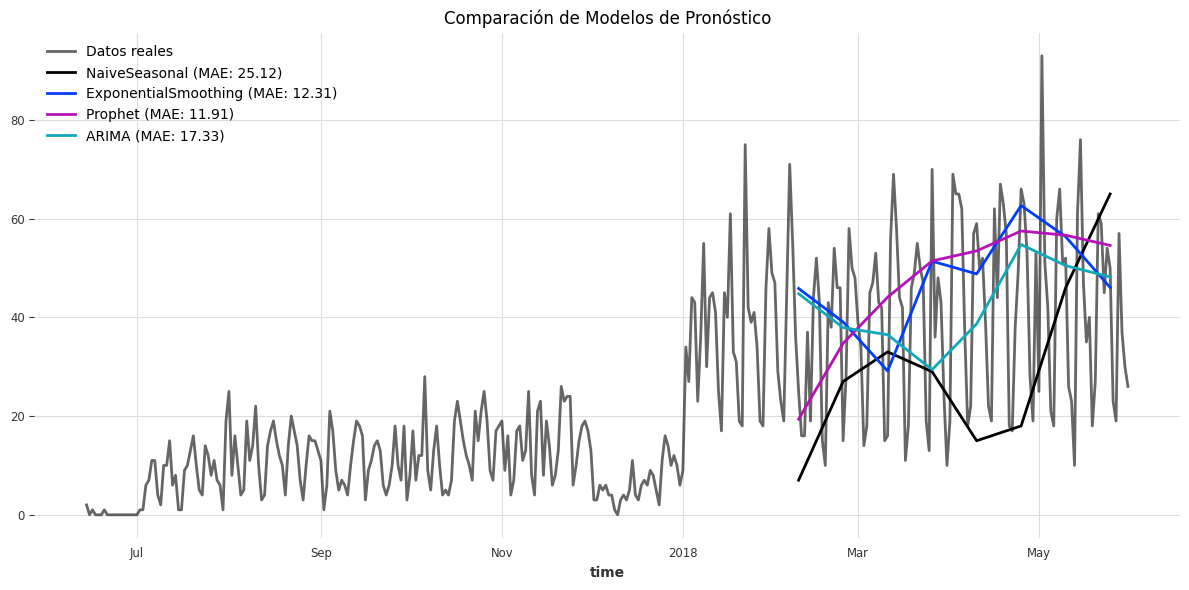

In [254]:
# Elegir modelos a comparar
models = [
    NaiveSeasonal(K=52),
    ExponentialSmoothing(),
    Prophet(),
    ARIMA()  # En Darts, ARIMA determina automáticamente los parámetros por defecto
]

# Crear DataFrame para almacenar resultados
results = pd.DataFrame(columns=["Model", "MAE"])

# Configurar gráfico
plt.figure(figsize=(12, 6))
series.plot(label="Datos reales", color='black', alpha=0.6)

# Guardar resultados
for model in models:
    try:
        model_name = model.__class__.__name__
        print(f"Entrenando {model_name}...")
        
        # Entrenar modelo
        model.fit(series)
        
        # Backtesting con Darts
        # En Darts, usamos la función backtest
        forecast = model.historical_forecasts(
            series,
            start=int(len(series) * 0.6),  # En Darts, start es un índice
            forecast_horizon=30,
            stride=15,
            retrain=True,
            verbose=True
        )
        
        # Calcular error
        score = mae(series, forecast)
        print(f"{model_name} - MAE: {score:.2f}")
        
        # Guardar resultado
        results = pd.concat([results, pd.DataFrame({"Model": [model_name], "MAE": [score]})], ignore_index=True)
        
        # Añadir al gráfico
        forecast.plot(label=f"{model_name} (MAE: {score:.2f})")
        
    except Exception as e:
        print(f"Error con {model_name}: {e}")

# Finalizar gráfico
plt.title("Comparación de Modelos de Pronóstico")
plt.legend()
plt.tight_layout()

# Mostrar tabla de resultados ordenada
print("\nResultados finales:")
print(results.sort_values("MAE"))
#
# Crear directorio si no existe
output_dir = '../outputs/figures' # Ruta relativa desde la carpeta notebooks
os.makedirs(output_dir, exist_ok=True) 

# Guardar la figura
plt.savefig(os.path.join(output_dir, 'comparacion_modelos_pronostico.png'), dpi=300) 
plt.show()

## **Modelamiento Semanal mqls**

In [8]:
# Asumiendo que 'first_contact_date' es el índice datetime
mql_daily_series_pd = mql_daily_series.query(" first_contact_date <= '2018-05-28' ").set_index('first_contact_date')

mql_weekly_series_pd = mql_daily_series_pd.resample('W-MON').sum() # O 'W-MON' para inicio de semana, etc.

# Luego crear el TimeSeries de Darts desde mql_weekly_series_pd
series_weekly = TimeSeries.from_dataframe(mql_weekly_series_pd.reset_index(), 
                                          time_col='first_contact_date', # O el nombre que quede tras reset_index
                                          value_cols='mql_count',
                                          freq='W-MON') # Asegúrate que la freq coincida

24


<Figure size 1600x1000 with 0 Axes>

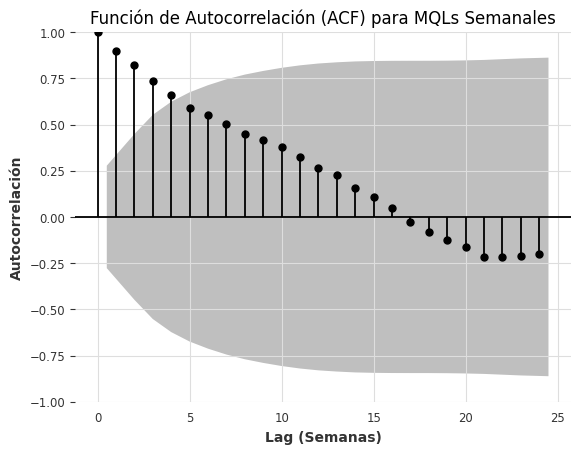

In [256]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd # Asegúrate de importar pandas

# --- Asumiendo que 'series_weekly' es tu Darts TimeSeries ---
# Necesitamos la serie como pandas Series para statsmodels
pd_series = mql_weekly_series_pd

max_lags = min(len(pd_series) // 2 - 1, 70)
print(max_lags) # Ejemplo: hasta 120 o la mitad de la serie

plt.figure(figsize=(16, 10))
plot_acf(pd_series, lags=max_lags) 
plt.xlabel("Lag (Semanas)")
plt.ylabel("Autocorrelación")
plt.title("Función de Autocorrelación (ACF) para MQLs Semanales")
plt.grid(True)
#
# Guardar la figura
os.makedirs(output_dir, exist_ok=True) 

# Guardar la figura
plt.savefig(os.path.join(output_dir, 'acf_mqls_semanales.png'), dpi=100) 
#
plt.show()

Entrenando ARIMA...


historical forecasts:   0%|          | 0/9 [00:00<?, ?it/s]

C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

C:\Users\Acer\AppData\Local\Temp\ipykernel_9292\2975190973.py:45: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


ARIMA - MAE: 43.15
Entrenando LinearRegressionModel...


historical forecasts:   0%|          | 0/9 [00:00<?, ?it/s]

LinearRegressionModel - MAE: 97.94
Entrenando ExponentialSmoothing...
Error con ExponentialSmoothing: 'str' object has no attribute 'value'
Entrenando Prophet...


17:35:41 - cmdstanpy - INFO - Chain [1] start processing
17:35:42 - cmdstanpy - INFO - Chain [1] done processing


historical forecasts:   0%|          | 0/9 [00:00<?, ?it/s]

17:35:42 - cmdstanpy - INFO - Chain [1] start processing
17:35:42 - cmdstanpy - INFO - Chain [1] done processing
17:35:42 - cmdstanpy - INFO - Chain [1] start processing
17:35:42 - cmdstanpy - INFO - Chain [1] done processing
17:35:42 - cmdstanpy - INFO - Chain [1] start processing
17:35:43 - cmdstanpy - INFO - Chain [1] done processing
17:35:43 - cmdstanpy - INFO - Chain [1] start processing
17:35:43 - cmdstanpy - INFO - Chain [1] done processing
17:35:43 - cmdstanpy - INFO - Chain [1] start processing
17:35:43 - cmdstanpy - INFO - Chain [1] done processing
17:35:44 - cmdstanpy - INFO - Chain [1] start processing
17:35:44 - cmdstanpy - INFO - Chain [1] done processing
17:35:44 - cmdstanpy - INFO - Chain [1] start processing
17:35:44 - cmdstanpy - INFO - Chain [1] done processing
17:35:44 - cmdstanpy - INFO - Chain [1] start processing
17:35:44 - cmdstanpy - INFO - Chain [1] done processing
17:35:45 - cmdstanpy - INFO - Chain [1] start processing
17:35:45 - cmdstanpy - INFO - Chain [1]

Prophet - MAE: 47.21
Entrenando NaiveDrift...


historical forecasts:   0%|          | 0/9 [00:00<?, ?it/s]

NaiveDrift - MAE: 44.19
Entrenando Theta...


historical forecasts:   0%|          | 0/9 [00:00<?, ?it/s]

Theta - MAE: 58.52


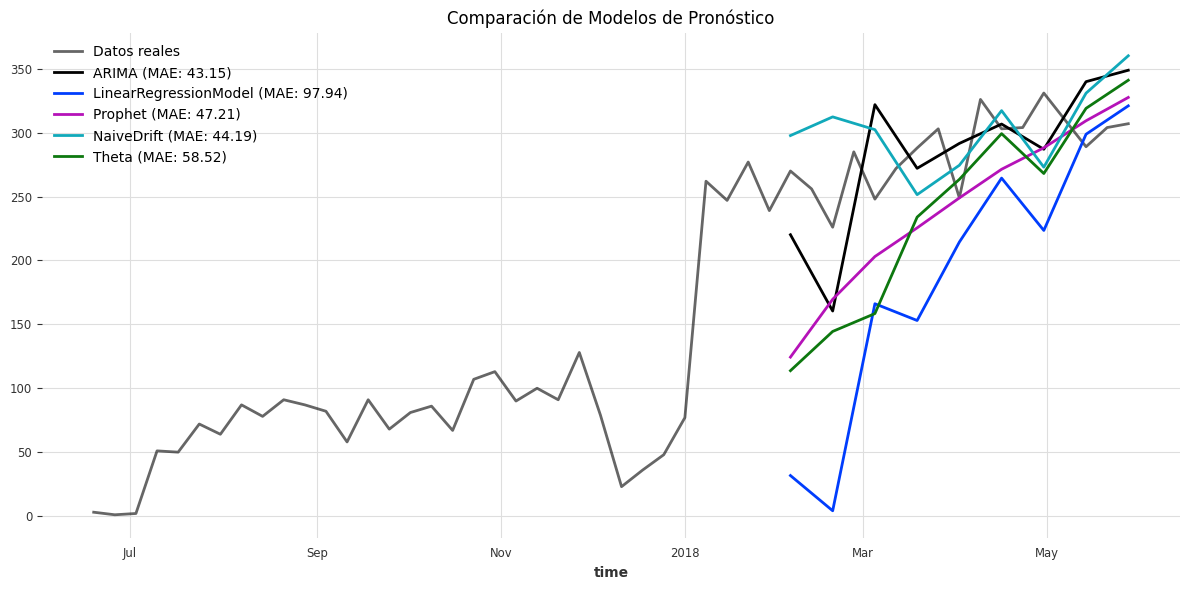


Resultados finales:
                   Model        MAE
0                  ARIMA  43.147722
3             NaiveDrift  44.192965
2                Prophet  47.205880
4                  Theta  58.521536
1  LinearRegressionModel  97.937574


In [257]:
# Elegir modelos a comparar
models = [
    ARIMA(p=1, d=1, q=0, seasonal_order=(1, 1, 1, 4)),
    LinearRegressionModel(lags=3),
    ExponentialSmoothing(seasonal='None'),
    Prophet(),
    NaiveDrift(),
    Theta(),
 # En Darts, ARIMA determina automáticamente los parámetros por defecto
]

# Crear DataFrame para almacenar resultados
results = pd.DataFrame(columns=["Model", "MAE"])


# Configurar gráfico
plt.figure(figsize=(12, 6))
series_weekly.plot(label="Datos reales", color='black', alpha=0.6)

# Guardar resultados
for model in models:
    try:
        model_name = model.__class__.__name__
        print(f"Entrenando {model_name}...")
        
        # Entrenar modelo
        model.fit(series_weekly)
        
        # Backtesting con Darts
        # En Darts, usamos la función backtest
        forecast = model.historical_forecasts(
            series_weekly,
            start=int(len(series_weekly) * 0.6),  # En Darts, start es un índice
            forecast_horizon=4,
            stride=2,
            retrain=True,
            verbose=True
        )
        
        # Calcular error
        score = mae(series_weekly, forecast)
        print(f"{model_name} - MAE: {score:.2f}")
        
        # Guardar resultado
        results = pd.concat([results, pd.DataFrame({"Model": [model_name], "MAE": [score]})], ignore_index=True)
        
        # Añadir al gráfico
        forecast.plot(label=f"{model_name} (MAE: {score:.2f})")
        
    except Exception as e:
        print(f"Error con {model_name}: {e}")

# Finalizar gráfico
plt.title("Comparación de Modelos de Pronóstico")
plt.legend()
plt.tight_layout()
#
# Guardar la figura
os.makedirs(output_dir, exist_ok=True) 

# Guardar la figura
plt.savefig(os.path.join(output_dir, 'comparacion_modelos_pronostico_semanales.png'), dpi=300) 
#
plt.show()

# Mostrar tabla de resultados ordenada
print("\nResultados finales:")
print(results.sort_values("MAE"))

## **Predicción Semanal de mqls**

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Suponiendo que `serie` es un pandas Series con índice de tiempo
modelo = SARIMAX(mql_weekly_series_pd, order=(1, 1, 0), seasonal_order=(1, 1, 1, 4))
#
resultado = modelo.fit(disp=False)

In [11]:
print(resultado.summary())

                                      SARIMAX Results                                      
Dep. Variable:                           mql_count   No. Observations:                   50
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 4)   Log Likelihood                -232.339
Date:                             Thu, 24 Apr 2025   AIC                            472.677
Time:                                     19:57:00   BIC                            479.904
Sample:                                 06-19-2017   HQIC                           475.371
                                      - 05-28-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2697      0.165     -1.634      0.102      -0.593       0.054
ar.S.L4       -0.1833      

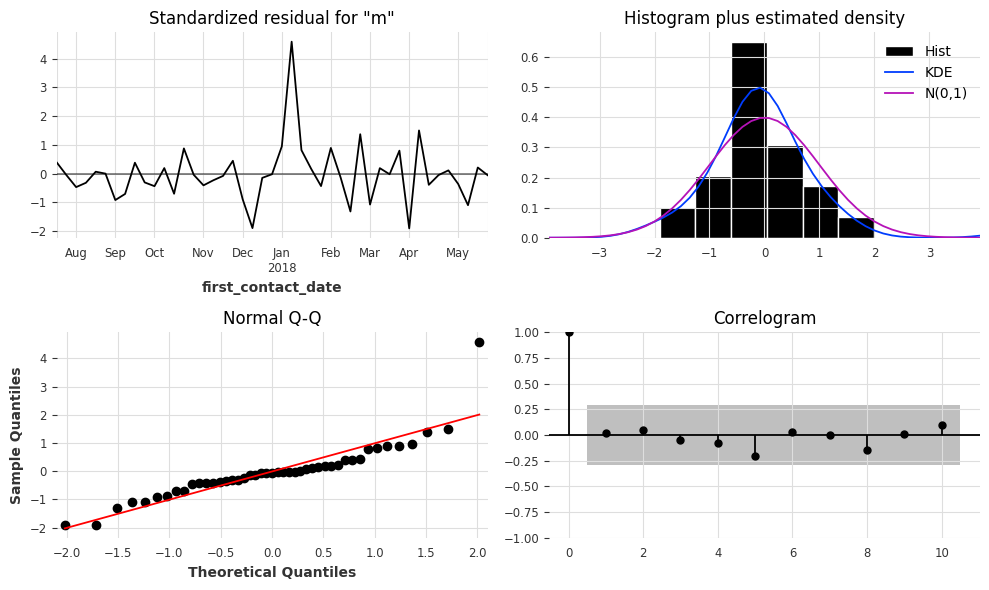

In [12]:
resultado.plot_diagnostics(figsize=(10, 6))
plt.tight_layout()
plt.show()

In [22]:
# Futuro: predicción de los próximos 12 pasos
pasos = 13
pred_out = resultado.get_forecast(steps=pasos)
pred_out_ci = pred_out.conf_int()

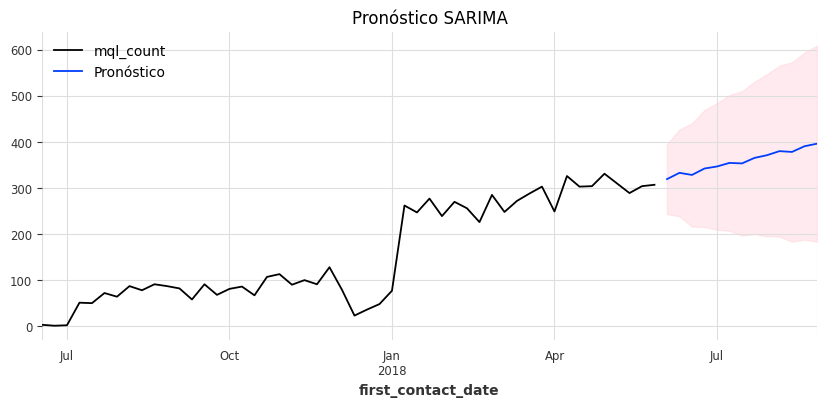

In [24]:
ax = mql_weekly_series_pd.plot(label='Observado', figsize=(10, 4))
pred_out.predicted_mean.plot(ax=ax, label='Pronóstico')

# Rellenar el intervalo de confianza
ax.fill_between(pred_out_ci.index,
                pred_out_ci.iloc[:, 0],
                pred_out_ci.iloc[:, 1], color='pink', alpha=0.3)

plt.title('Pronóstico SARIMA')
plt.legend()
plt.show()

In [43]:
valores_predichos = pred_out.predicted_mean
#
df_predicciones = valores_predichos.reset_index().round(0)
df_predicciones.columns = ['first_contact_date', 'mql_count']
df_predicciones['Data Type'] = 'Predicted'
#
mql_weekly_series_pd_reset = mql_weekly_series_pd.reset_index()
mql_weekly_series_pd_reset['Data Type'] = 'Actual'

In [244]:
# Crear la figura
fig = go.Figure()

# Añadir la traza de datos históricos reales
fig.add_trace(go.Scatter(x=mql_weekly_series_pd_reset.index, y=mql_weekly_series_pd_reset['Actual MQLs'],
                    mode='lines',
                    name='Actual MQLs'))

# Añadir la traza de la predicción
# Asegúrate de que forecast_df no esté vacío después del procesamiento
if not df_predicciones.empty:
    fig.add_trace(go.Scatter(x=df_predicciones.index, y=df_predicciones['Predicted MQLs'],
                        mode='lines',
                        name='Predicted MQLs (SARIMA)',
                        line=dict(dash='dash'))) # Estilo de línea diferente

# Actualizar el layout de la gráfica
fig.update_layout(
    title='Actual vs. Predicted Weekly MQLs',
    xaxis_title='Date',
    yaxis_title='MQL Count',
    legend_title='Series',
    hovermode="x unified" # Mejora la interactividad del tooltip
)

# Mostrar la figura interactiva
fig.show()


DataFrame combinado (últimas filas):
component           Actual MQLs  Data Type
first_contact_date                        
2018-07-30                371.0  Predicted
2018-08-06                380.0  Predicted
2018-08-13                378.0  Predicted
2018-08-20                391.0  Predicted
2018-08-27                396.0  Predicted


## **Agrupación Mensual de Predicción mqls**

In [240]:
#
df_concat = pd.concat([mql_weekly_series_pd_reset, df_predicciones], axis=0)
df_concat['contact_period'] = df_concat['first_contact_date'].astype(str).str[:7]
#
df_predict_agg = df_concat.groupby(['contact_period', 'Data Type']).agg(mql_count=('mql_count', 'sum')).reset_index()

In [45]:
px.line(df_predict_agg, x='contact_period', y='mql_count', color='Data Type', title='MQLs por contact_period')